<a href="https://colab.research.google.com/github/VellummyilumVinoth/Aspect_based_sentimental_analysis/blob/main/daraz_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 1: Install the required libraries
! pip install transformers

from transformers import BertForSequenceClassification, BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.7 MB/s eta 0:00:00


In [4]:
import torch
from torch import cuda
device = torch.device('cuda' if cuda.is_available() else 'cpu')

print(f"Current device: {device}")

Current device: cuda


In [5]:
# Step 2: Load the fine-tuned BERT model and its tokenizer
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/zidan/finetuned_bert",num_labels=7)
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/zidan/finetuned_bert', do_lower_case=True)

In [6]:
# Step 3: Load and preprocess your CSV dataset

import pandas as pd
predict_data = pd.read_csv("/content/drive/MyDrive/zidan/daraz_preprocessed_data.csv")


In [7]:
predict_data

,Product Name,Category,Rating,Reviewer Name,Review,Review_without_emoji,preprocess_text,preprocess_text1
0,"Sunlight Care Detergent Liquid, 1L",Laundry,1.0,Eranga D,I purchased 2 bottles. Both seem partially use...,I purchased 2 bottles. Both seem partially use...,i purchased 2 bottles both seem partially used...,"['purchased', '2', 'bottles', 'seem', 'partial..."
1,"Sunlight Care Detergent Liquid, 1L",Laundry,5.0,Suranga Y,Very fast & safe delivery . Neet packing. I wi...,Very fast & safe delivery . Neet packing. I wi...,very fast safe delivery neet packing i wish ...,"['fast', 'safe', 'delivery', 'neet', 'packing'..."
2,"Sunlight Care Detergent Liquid, 1L",Laundry,5.0,Ishini F,Fast delivery during this pandemic. Got the pr...,Fast delivery during this pandemic. Got the pr...,fast delivery during this pandemic got the pro...,"['fast', 'delivery', 'pandemic', 'got', 'produ..."
3,"Sunlight Care Detergent Liquid, 1L",Laundry,1.0,Dr. K,Alot of liquid has leaked.im very much disappo...,Alot of liquid has leaked.im very much disappo...,alot of liquid has leakedim very much disappoi...,"['alot', 'liquid', 'leakedim', 'much', 'disapp..."
4,"Sunlight Care Detergent Liquid, 1L",Laundry,5.0,Rajitha S.,Thank you very much !! I received my package t...,Thank you very much !! I received my package t...,thank you very much i received my package tod...,"['thank', 'much', 'received', 'package', 'toda..."
...,...,...,...,...,...,...,...,...
1837,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,4.0,by ******576,very good product value for the price,very good product value for the price,very good product value for the price,"['good', 'product', 'value', 'price']"
1838,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,4.0,by ruchira K.,Delivery within 1day to Tangalle... well packe...,Delivery within 1day to Tangalle... well packe...,delivery within 1day to tangalle well packedco...,"['delivery', 'within', '1day', 'tangalle', 'we..."
1839,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,3.0,by Sivathas J.,high quality reasonable price,high quality reasonable price,high quality reasonable price,"['high', 'quality', 'reasonable', 'price']"
1840,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,4.0,by Poornamith,Excellent packaging. And it was delivered quic...,Excellent packaging. And it was delivered quic...,excellent packaging and it was delivered quick...,"['excellent', 'packaging', 'delivered', 'quick..."


In [8]:
review = list(predict_data.Review_without_emoji.values)

In [9]:
# Step 5: Tokenize and process reviews in batches
batch_size = 1000
encoded_inputs = []
for i in range(0, len(review), batch_size):
    batch = review[i:i+batch_size]
    batch_encoded = tokenizer.batch_encode_plus(batch, padding=True, truncation=True, return_tensors='pt')
    encoded_inputs.append(batch_encoded)

# Step 6: Pass the tokenized inputs through the model to get the predictions
predicted_labels = []
with torch.no_grad():
    model.eval()
    for batch_encoded in encoded_inputs:
        batch_outputs = model(**batch_encoded)
        batch_predicted_labels = batch_outputs.logits
        predicted_labels.append(batch_predicted_labels)

# Concatenate the predictions from all batches
predicted_labels = torch.cat(predicted_labels)

In [10]:
# Step 7: Map the predicted labels back to their respective class names
class_names = ['price', 'quality', 'delivery cost', 'packaging', 'design', 'customer service', 'usability']

# Step 7: Apply a threshold and convert to binary values
threshold = 0.5  # Adjust the threshold as needed

predicted_labels = (torch.sigmoid(predicted_labels) > threshold).to(torch.int).tolist()

# Create a new DataFrame with the predicted labels
label_df = pd.DataFrame(predicted_labels, columns=class_names)

# Concatenate the original DataFrame with the label DataFrame
result_df = pd.concat([predict_data, label_df], axis=1)

# Save the result DataFrame as a new CSV file
result_df.to_csv('/content/drive/MyDrive/zidan/daraz_predictions.csv', index= False)

In [11]:
result_df

,Product Name,Category,Rating,Reviewer Name,Review,Review_without_emoji,preprocess_text,preprocess_text1,price,quality,delivery cost,packaging,design,customer service,usability
0,"Sunlight Care Detergent Liquid, 1L",Laundry,1.0,Eranga D,I purchased 2 bottles. Both seem partially use...,I purchased 2 bottles. Both seem partially use...,i purchased 2 bottles both seem partially used...,"['purchased', '2', 'bottles', 'seem', 'partial...",1,1,0,1,0,0,1
1,"Sunlight Care Detergent Liquid, 1L",Laundry,5.0,Suranga Y,Very fast & safe delivery . Neet packing. I wi...,Very fast & safe delivery . Neet packing. I wi...,very fast safe delivery neet packing i wish ...,"['fast', 'safe', 'delivery', 'neet', 'packing'...",1,0,1,1,0,0,0
2,"Sunlight Care Detergent Liquid, 1L",Laundry,5.0,Ishini F,Fast delivery during this pandemic. Got the pr...,Fast delivery during this pandemic. Got the pr...,fast delivery during this pandemic got the pro...,"['fast', 'delivery', 'pandemic', 'got', 'produ...",0,0,1,1,0,1,0
3,"Sunlight Care Detergent Liquid, 1L",Laundry,1.0,Dr. K,Alot of liquid has leaked.im very much disappo...,Alot of liquid has leaked.im very much disappo...,alot of liquid has leakedim very much disappoi...,"['alot', 'liquid', 'leakedim', 'much', 'disapp...",0,0,0,1,0,0,0
4,"Sunlight Care Detergent Liquid, 1L",Laundry,5.0,Rajitha S.,Thank you very much !! I received my package t...,Thank you very much !! I received my package t...,thank you very much i received my package tod...,"['thank', 'much', 'received', 'package', 'toda...",0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,4.0,by ******576,very good product value for the price,very good product value for the price,very good product value for the price,"['good', 'product', 'value', 'price']",1,0,0,0,0,0,0
1838,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,4.0,by ruchira K.,Delivery within 1day to Tangalle... well packe...,Delivery within 1day to Tangalle... well packe...,delivery within 1day to tangalle well packedco...,"['delivery', 'within', '1day', 'tangalle', 'we...",1,0,1,1,0,1,0
1839,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,3.0,by Sivathas J.,high quality reasonable price,high quality reasonable price,high quality reasonable price,"['high', 'quality', 'reasonable', 'price']",1,1,0,0,0,0,0
1840,Sustagen Nutritional Supplement Chocolate Flav...,MilkPowder,4.0,by Poornamith,Excellent packaging. And it was delivered quic...,Excellent packaging. And it was delivered quic...,excellent packaging and it was delivered quick...,"['excellent', 'packaging', 'delivered', 'quick...",1,1,1,1,0,1,0


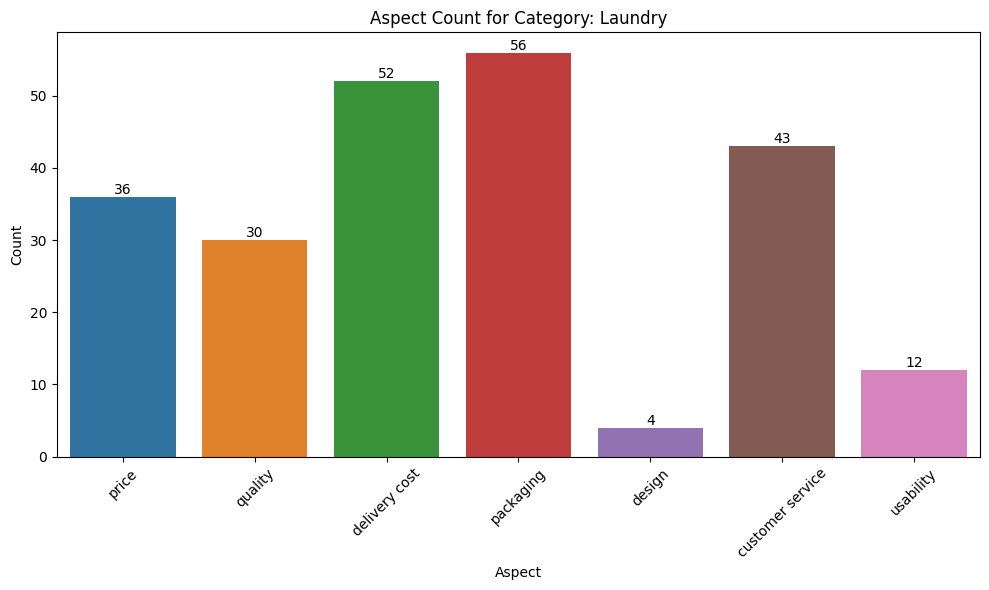

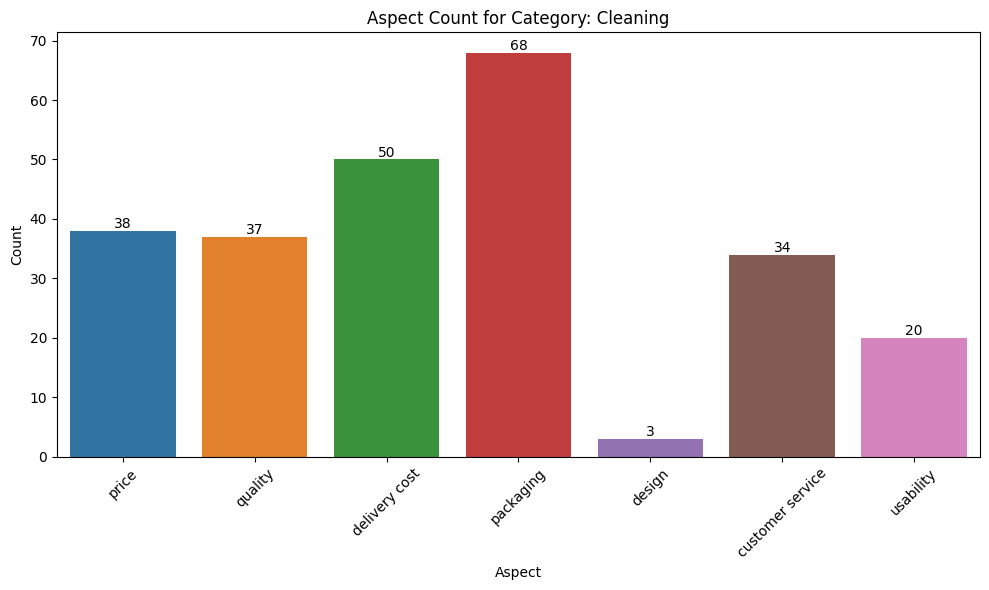

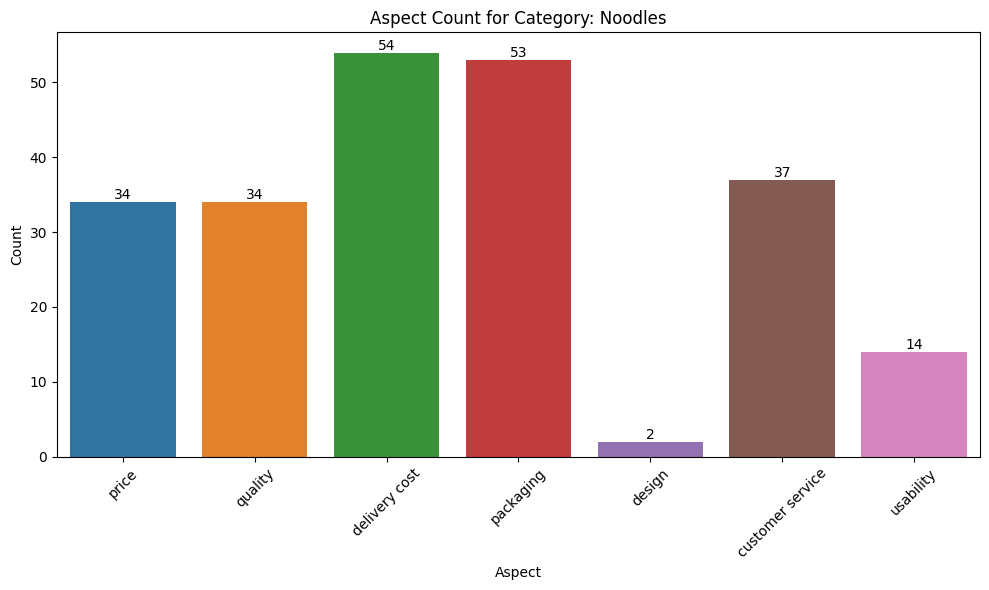

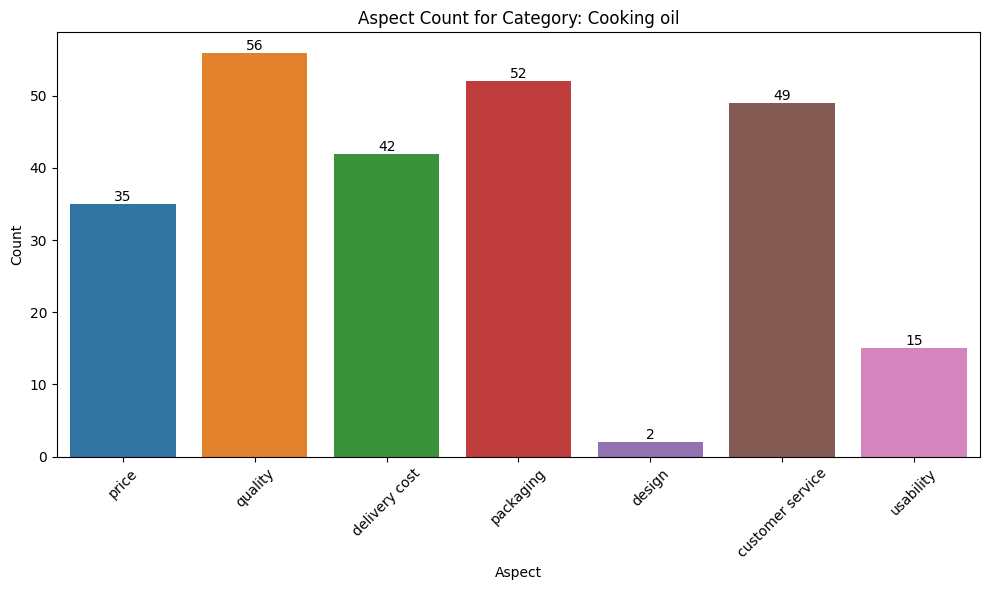

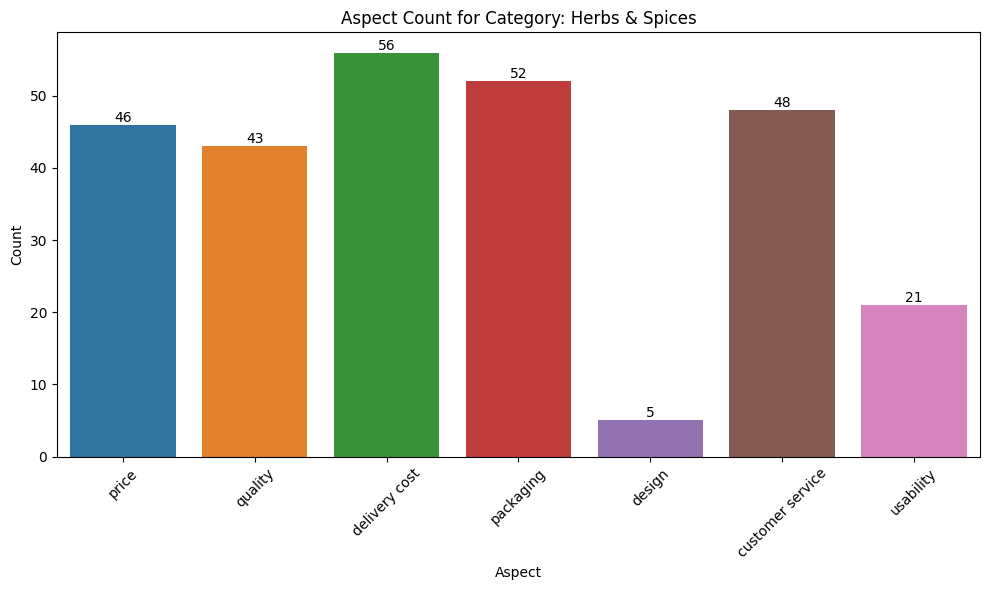

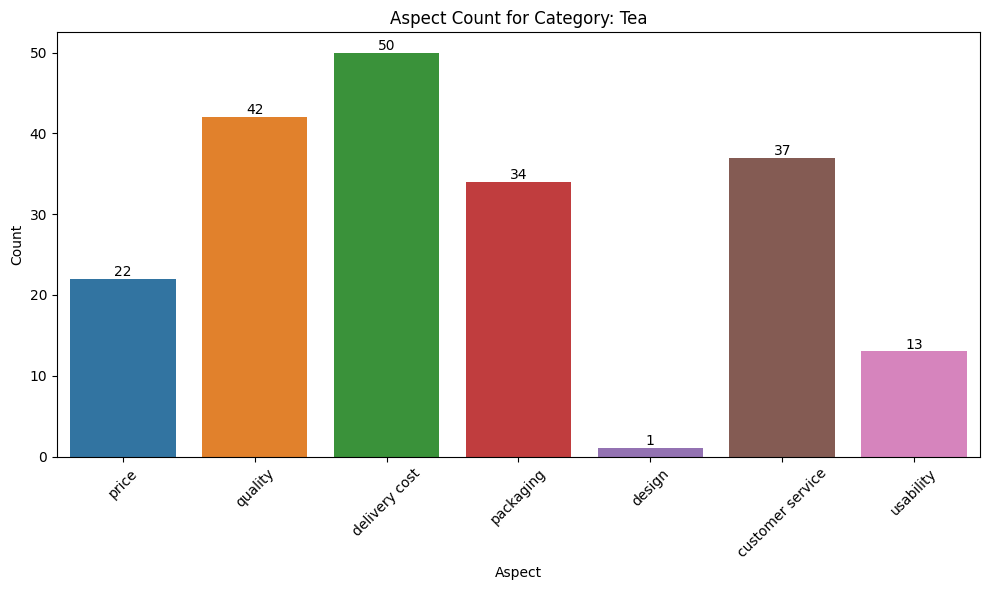

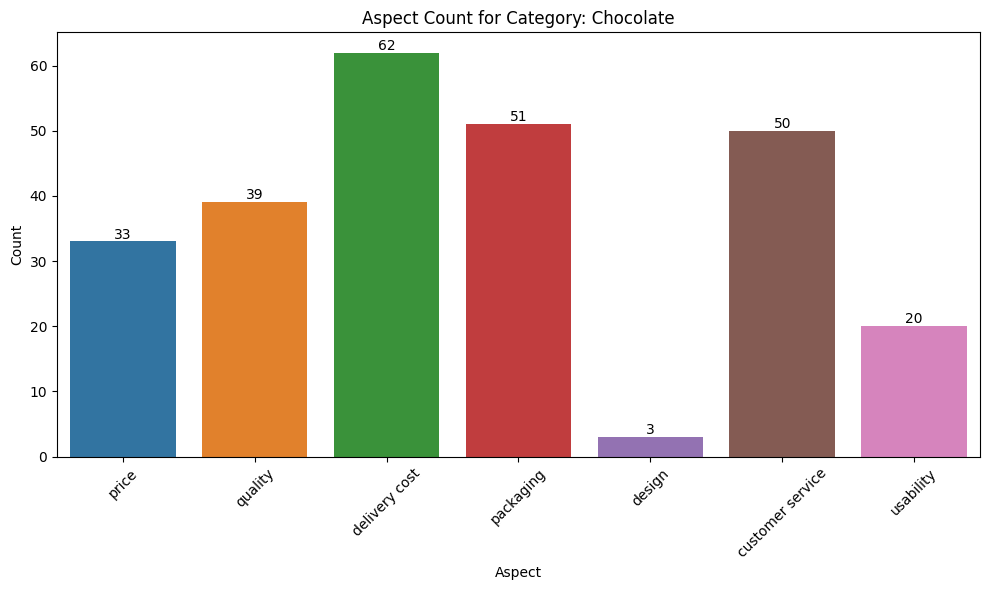

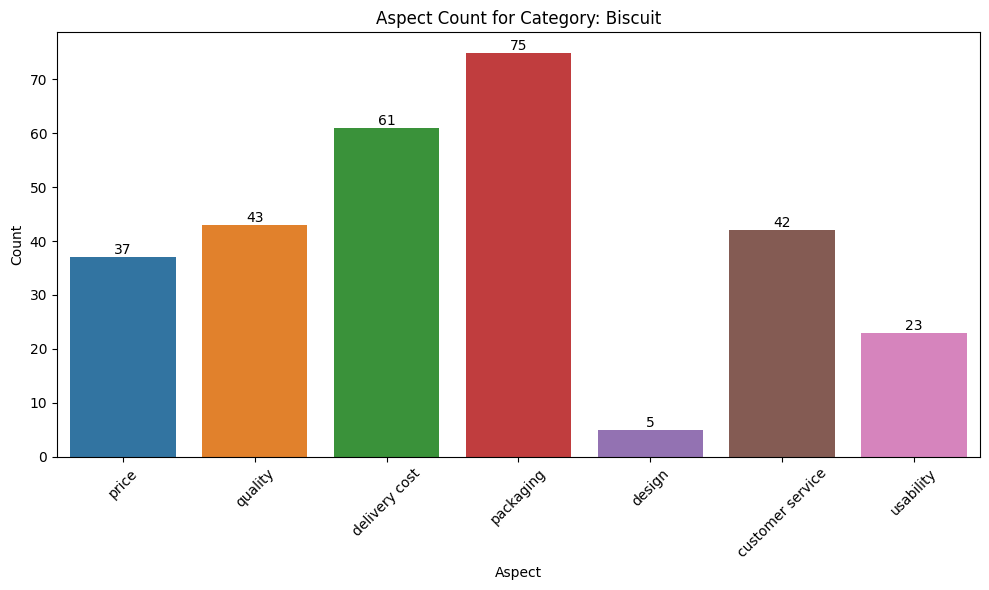

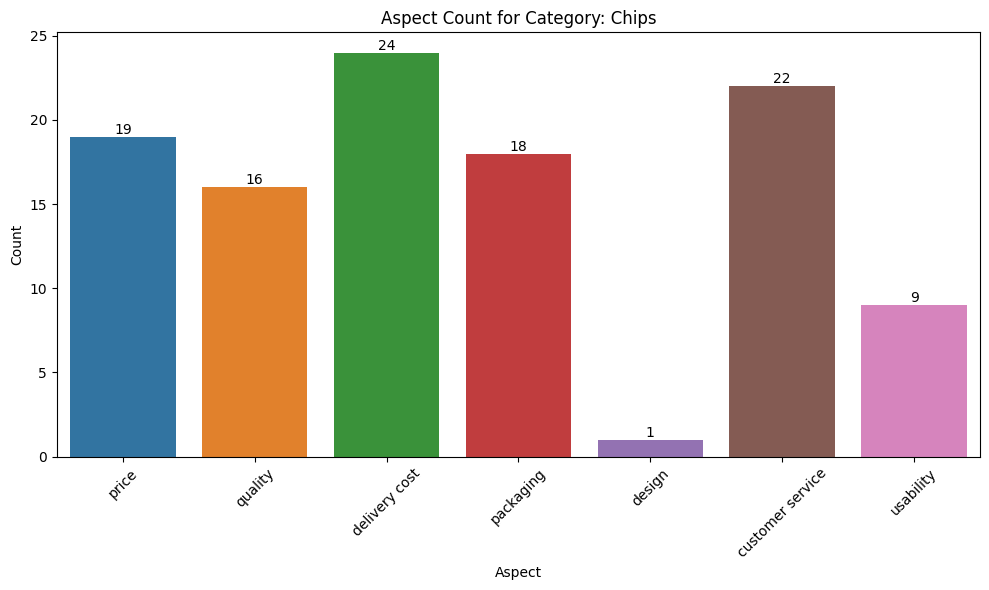

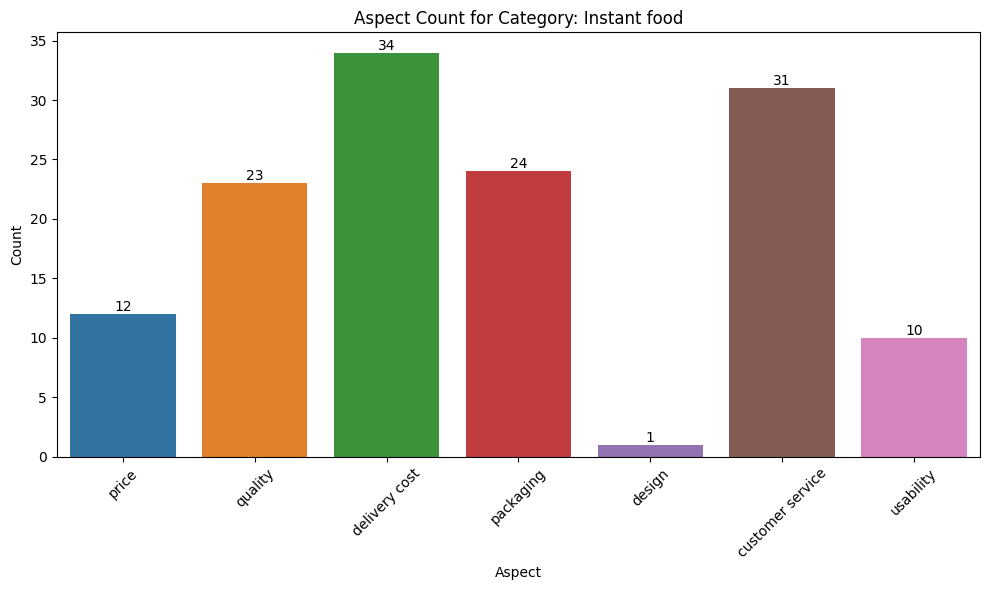

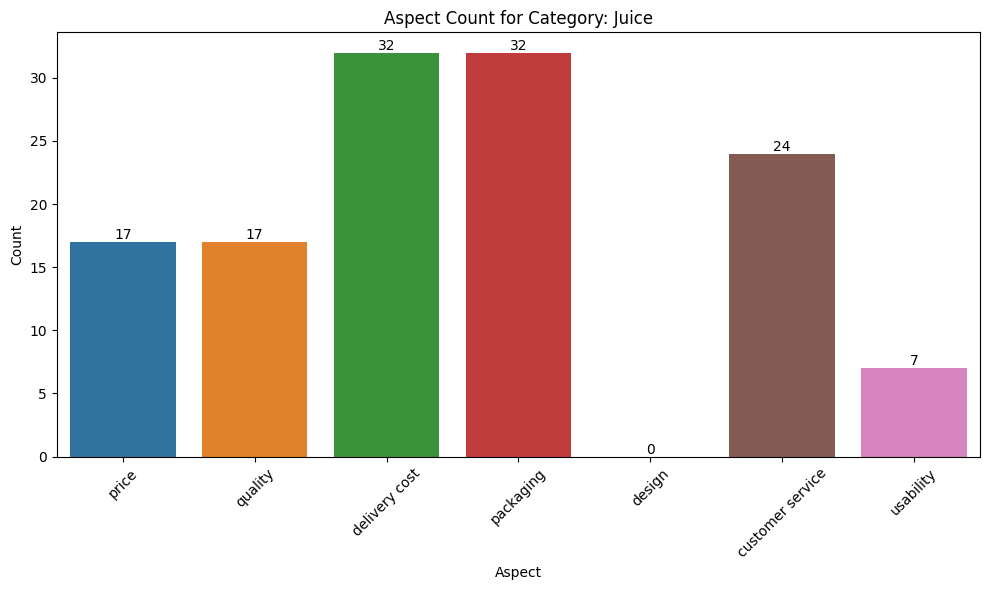

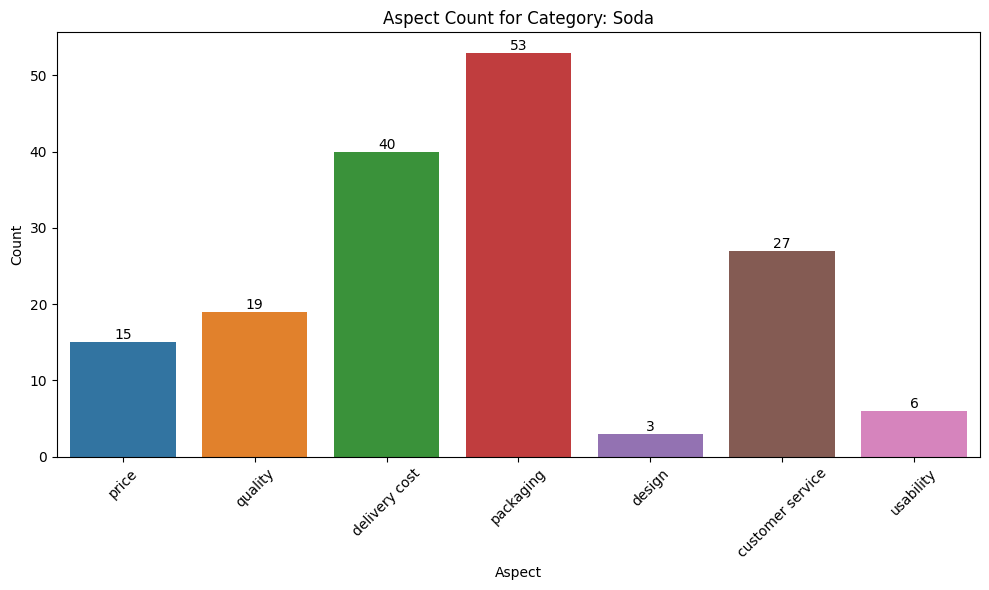

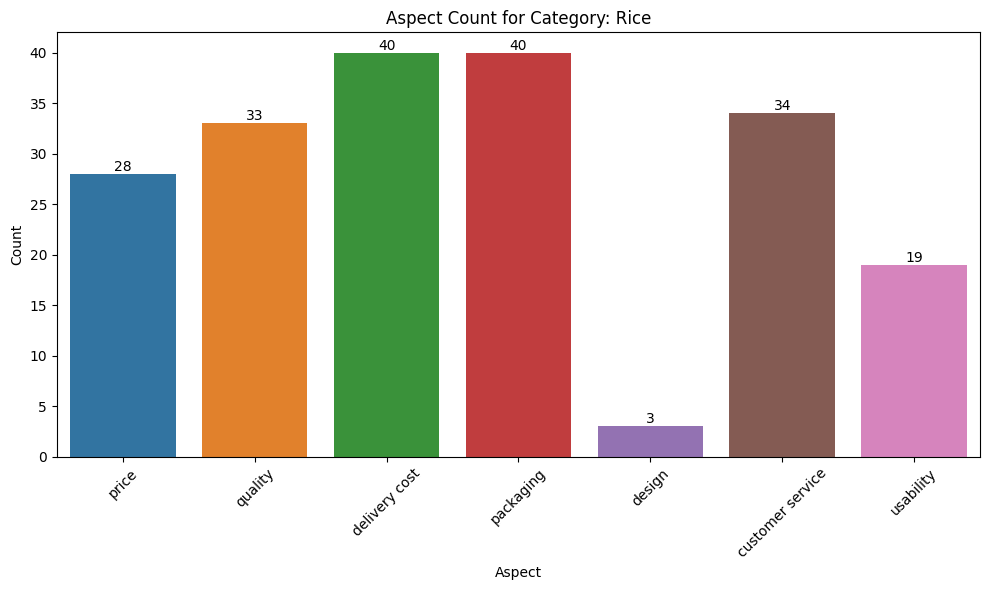

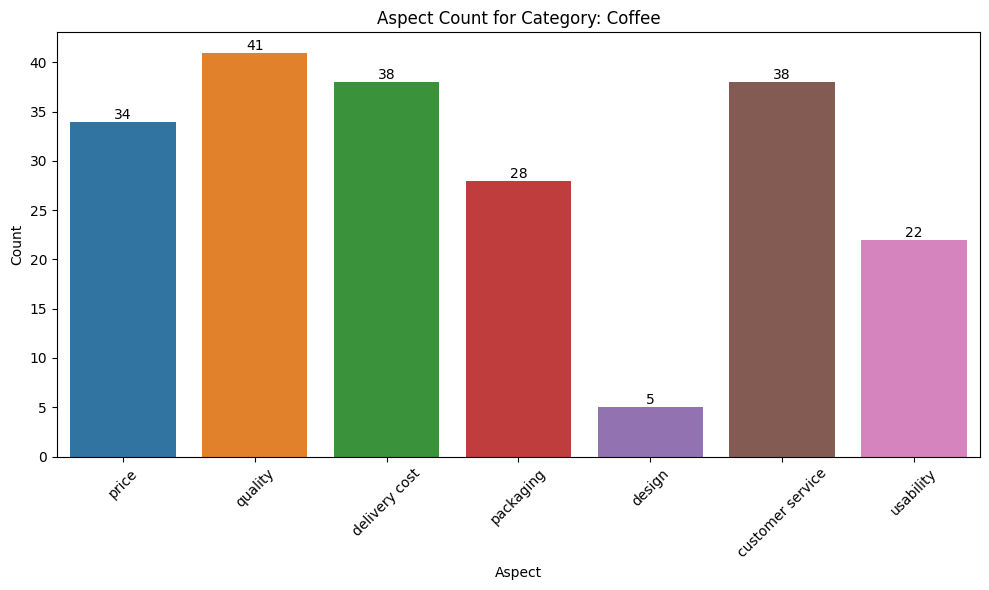

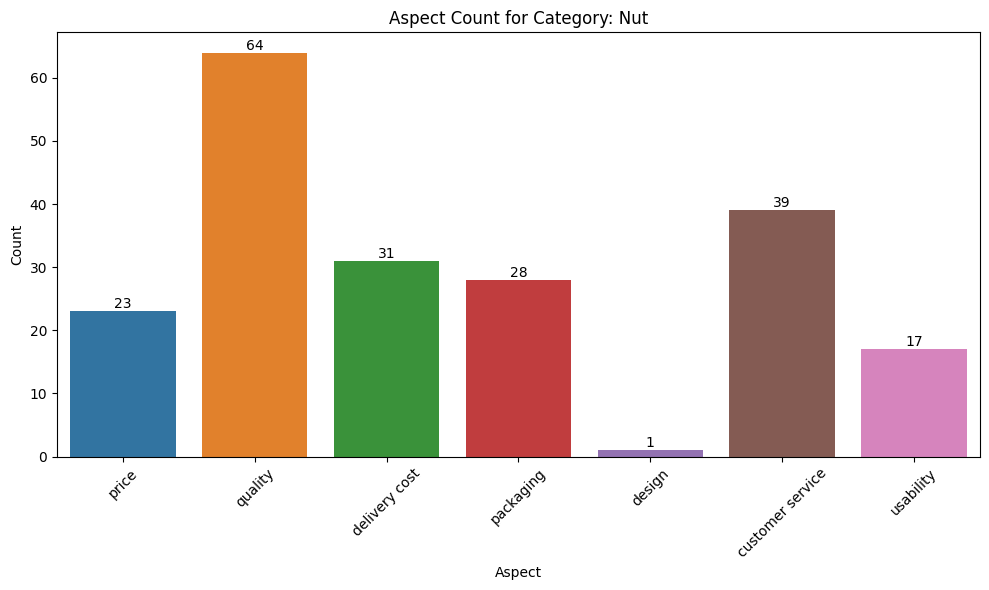

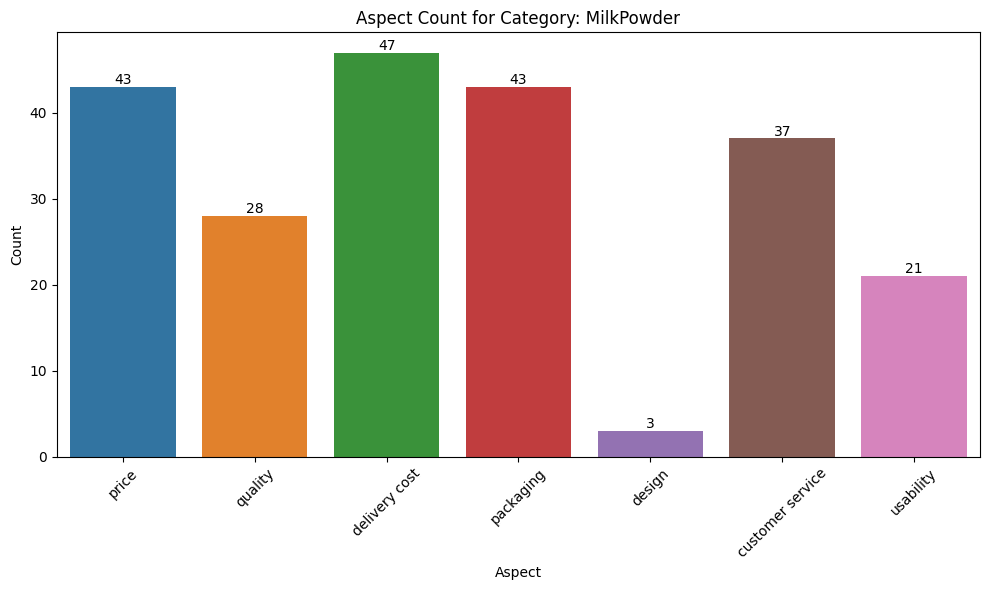

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of aspects
aspects = ['price', 'quality', 'delivery cost', 'packaging', 'design', 'customer service', 'usability']

# Extract unique categories from the DataFrame
unique_categories = result_df['Category'].unique()

# Iterate over each category and create a separate bar chart
for category in unique_categories:
    # Filter the DataFrame for the current category
    category_df = result_df[result_df['Category'] == category]

    # Calculate the aspect counts for the current category
    aspect_counts = category_df[aspects].sum()

    # Create a bar chart for the aspect counts
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=aspects, y=aspect_counts.values)
    plt.xlabel('Aspect')
    plt.ylabel('Count')
    plt.title(f'Aspect Count for Category: {category}')
    plt.xticks(rotation=45)

    # Display the aspect count values on the bars
    for p, count in zip(ax.patches, aspect_counts.values):
        ax.annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()


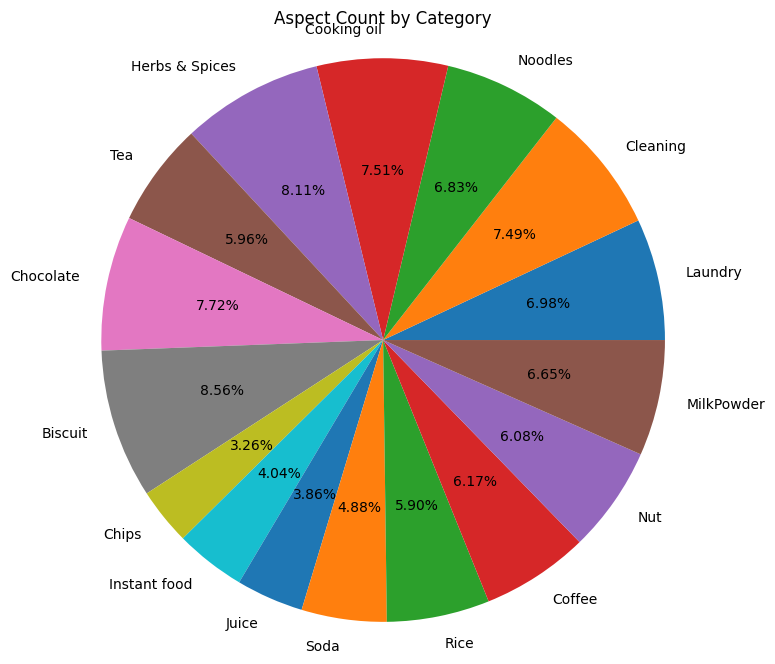

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the list of aspects
aspects = ['price', 'quality', 'delivery cost', 'packaging', 'design', 'customer service', 'usability']

# Extract unique categories and aspects from the DataFrame
unique_categories = result_df['Category'].unique()

# Create an empty dictionary to store the aspect counts
category_aspect_counts = {}

# Iterate over the DataFrame and count the aspects with label 1 for each category
for category in unique_categories:
    category_df = result_df[result_df['Category'] == category]
    category_aspect_counts[category] = category_df[aspects].sum().sum()

# Create a list of category names and their corresponding aspect counts
category_labels = list(category_aspect_counts.keys())
aspect_counts = list(category_aspect_counts.values())

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(aspect_counts, labels=category_labels, autopct='%2.2f%%')
plt.title('Aspect Count by Category')
plt.axis('equal')
plt.show()
